In [20]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv("../data/traffic_auto_daily.csv")
selected_pctf = [
    "SCULENI",
    "PALANCA",
    "CAHUL",
    "CRIVA"
]

df = df[df["pctf"].isin(selected_pctf)]
df.head()

,pctf,data,intrare_day,iesire_day,total_day,car_in,car_out,bus_in,bus_out,light_trucks_in,light_trucks_out,trucks_in,trucks_out,zi_sapt,month,is_weekend
2192,CAHUL,2022-12-01,512,447,959,267,288,6,14,5,14,234,131,4,12,0
2193,CAHUL,2022-12-02,431,393,824,275,271,6,8,6,11,144,103,5,12,0
2194,CAHUL,2022-12-03,431,528,959,297,374,6,6,10,10,118,138,6,12,1
2195,CAHUL,2022-12-04,521,719,1240,360,592,11,12,6,8,144,107,7,12,1
2196,CAHUL,2022-12-05,452,496,948,268,310,15,9,10,13,159,164,1,12,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4384 entries, 2192 to 21919
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   pctf              4384 non-null   object
 1   data              4384 non-null   object
 2   intrare_day       4384 non-null   int64 
 3   iesire_day        4384 non-null   int64 
 4   total_day         4384 non-null   int64 
 5   car_in            4384 non-null   int64 
 6   car_out           4384 non-null   int64 
 7   bus_in            4384 non-null   int64 
 8   bus_out           4384 non-null   int64 
 9   light_trucks_in   4384 non-null   int64 
 10  light_trucks_out  4384 non-null   int64 
 11  trucks_in         4384 non-null   int64 
 12  trucks_out        4384 non-null   int64 
 13  zi_sapt           4384 non-null   int64 
 14  month             4384 non-null   int64 
 15  is_weekend        4384 non-null   int64 
dtypes: int64(14), object(2)
memory usage: 582.2+ KB


In [23]:
df["data"] = pd.to_datetime(df["data"], errors="coerce")

In [77]:
#FEATURES
feature_cols = [
    "zi_sapt",
    "is_weekend",
    "car_in","car_out",
    "bus_in","bus_out",
    "trucks_in","trucks_out"
]

X = df[feature_cols].copy()

In [79]:
# SCALE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [80]:
# PCA
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

pca.explained_variance_ratio_.sum()

np.float64(0.7469467709157569)

In [81]:
def safe_silhouette(X, labels):
    uniq = set(labels)
    if len(uniq) < 2 or uniq == {-1}:
        return None
    if -1 in uniq:
        mask = labels != -1
        if len(set(labels[mask])) < 2:
            return None
        return silhouette_score(X[mask], labels[mask])
    return silhouette_score(X, labels)

def plot_clusters(X2d, labels, title):
    plt.figure()
    plt.scatter(X2d[:,0], X2d[:,1], c=labels, s=10)
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title(title)
    plt.show()


In [84]:
#KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X_scaled)

#sil_km = safe_silhouette(X_scaled, labels_km)
sil_km = silhouette_score(X_scaled, labels_km)
sil_km


0.3687470485170318

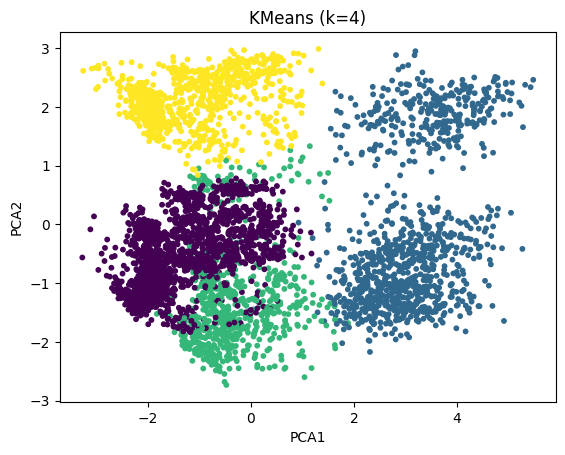

In [85]:
plot_clusters(X_2d, labels_km, "KMeans (k=4)")


In [89]:
#Agglomerative
agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
labels_agg = agg.fit_predict(X_scaled)

sil_agg = silhouette_score(X_scaled, labels_agg)
sil_agg


0.34965984103537673

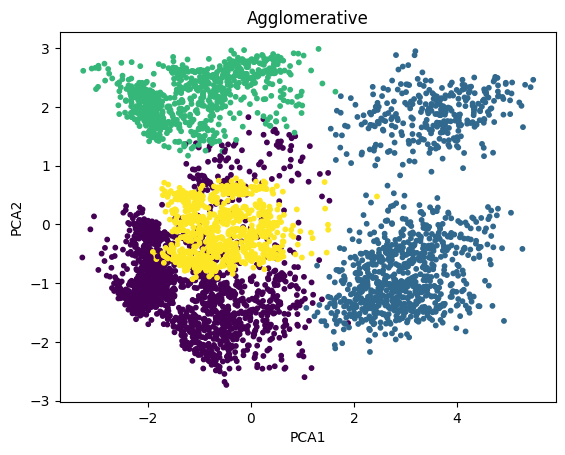

In [102]:
plot_clusters(X_2d, labels_agg, "Agglomerative")


In [99]:
# DBSCAN
db = DBSCAN(eps=1.2, min_samples=10)
labels_db = db.fit_predict(X_scaled)

sil_db = safe_silhouette(X_scaled, labels_db)
sil_db


0.2860080287746298

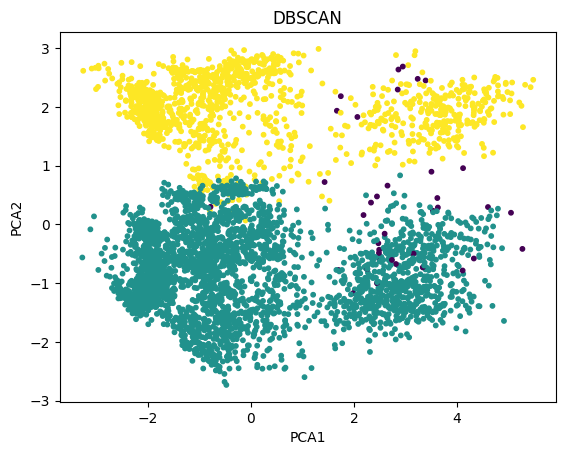

In [103]:
plot_clusters(X_2d, labels_db, "DBSCAN")


In [111]:
#Noise points
n_total = len(labels_db)
n_noise = (labels_db == -1).sum()

print("Noise points:", n_noise, "from total points:", n_total)


Noise points: 37 from total points: 4384


In [96]:
# GMM
gmm = GaussianMixture(n_components=4, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)

sil_gmm = silhouette_score(X_scaled, labels_gmm)
sil_gmm


0.2699816203408343

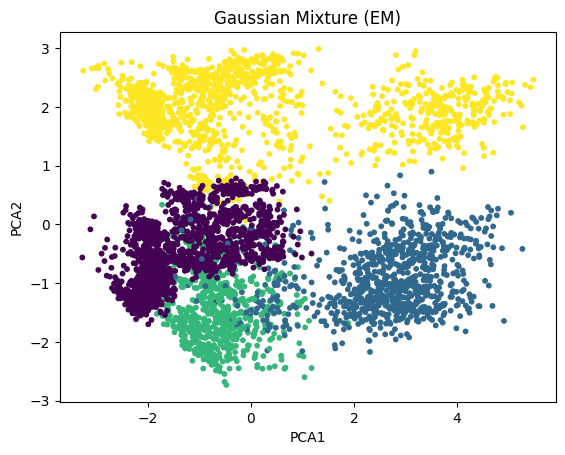

In [105]:
plot_clusters(X_2d, labels_gmm, "Gaussian Mixture (EM)")


In [107]:
results = pd.DataFrame({
    "Algoritm": ["KMeans", "Agglomerative", "DBSCAN", "GMM"],
    "Silhouette": [sil_km, sil_agg, sil_db, sil_gmm],
    "Noise_points(DBSCAN)": [np.nan, np.nan, (labels_db==-1).sum(), np.nan]
})

results


,Algoritm,Silhouette,Noise_points(DBSCAN)
0,KMeans,0.368747,NaN
1,Agglomerative,0.349660,NaN
2,DBSCAN,0.286008,37.0
3,GMM,0.269982,NaN
